In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import math
import h5py
import tensorflow as tf
from tensorflow.python.framework import ops
% matplotlib inline

In [2]:
5+5

10

In [3]:
data_size = 100000

In [4]:
# Load values in a more compact form
datatypes = {'key': 'str', 
              'fare_amount': 'float32',
               #'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

# Only a fraction of the whole data
train = pd.read_csv('train.csv',nrows = data_size, parse_dates=["pickup_datetime"], dtype=datatypes)
#data = pd.read_csv('train.csv')


In [5]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354651,-72.494682,39.914482,-72.490959,39.919056,1.673820
std,9.716777,10.693933,6.225686,10.471387,6.213427,1.300171
min,-44.900002,-736.549988,-74.007668,-84.654243,-74.006378,0.000000
25%,6.000000,-73.992043,40.734997,-73.991219,40.734180,1.000000
50%,8.500000,-73.981789,40.752766,-73.980003,40.753242,1.000000
75%,12.500000,-73.966980,40.767258,-73.963432,40.768166,2.000000
max,200.000000,40.787575,401.083344,40.851028,404.616669,6.000000


## delete null

In [6]:
print(train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [7]:
train = train.dropna(how = 'any', axis = 'rows')

In [8]:
len(train)

100000

## read test to find the boundry of the data

In [9]:
test = pd.read_csv('test.csv',parse_dates=["pickup_datetime"], dtype=datatypes)

In [10]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966049,40.789776,-73.988564,40.744427,1


In [11]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


## set the box

In [12]:
# pick up the long.max, long.min, lat.max, lat.min, used to tease out the train data.
long_max = max(test.pickup_longitude.max(),test.dropoff_longitude.max())
long_min = min(test.pickup_longitude.min(),test.dropoff_longitude.min())
lat_max = max(test.pickup_latitude.max(),test.dropoff_latitude.max())
lat_min = min(test.pickup_latitude.min(),test.dropoff_latitude.min())

In [13]:
area = [long_max,long_min,lat_max,lat_min]

In [14]:
for i in range(4):
    print(area[i],type(i))

-72.986534 <class 'int'>
-74.263245 <class 'int'>
41.709557 <class 'int'>
40.568974 <class 'int'>


In [15]:
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('nyc_origin.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('nyc_zoom.png')

## use box clean data

In [16]:
def clean(df,df_test,area,margin=0.1):
    # Delimiter lats and lons to NY only
    
    df=df[(BB[0] <= df['pickup_longitude']) & (df['pickup_longitude'] <= BB[1] )]
    df=df[(BB[0] <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= BB[1])]
    df=df[(BB[2] <= df['pickup_latitude']) & (df['pickup_latitude'] <= BB[3])]
    df=df[(BB[2] <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= BB[3])]
    
    assert df['pickup_longitude'].min()>BB[0] ,\
            df['pickup_longitude'].max()<BB[1]
    assert df['pickup_latitude'].min()>BB[2],\
            df['pickup_latitude'].max()<BB[3]
    assert df['dropoff_longitude'].min()>BB[0] ,\
            df['dropoff_longitude'].max()<BB[1]
    assert df['dropoff_latitude'].min()>BB[2],\
            df['dropoff_latitude'].max()<BB[3]          
    return df

In [17]:
train_data = clean(train,test,area)

In [18]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000,97871.000000
mean,11.341970,-73.974998,40.751225,-73.973923,40.751621,1.674337
std,9.684953,0.039134,0.030233,0.038175,0.033243,1.300270
min,-44.900002,-74.438232,40.500046,-74.474594,40.500046,0.000000
25%,6.000000,-73.992256,40.736666,-73.991394,40.735775,1.000000
50%,8.500000,-73.982079,40.753544,-73.980438,40.753971,1.000000
75%,12.500000,-73.968292,40.767687,-73.965126,40.768490,2.000000
max,200.000000,-72.856972,41.692429,-72.854942,41.714634,6.000000


## tease out outlier

### remove fare_amount < 0 and pickup&dropoff at the same location

In [19]:
def remove(df):
    df=df[(0 < df['fare_amount'])] # & (df['fare_amount'] <= 250)]


    df=df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df=df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

In [20]:
train_data = remove(train_data)

In [21]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96686.000000,96686.000000,96686.000000,96686.000000,96686.000000,96686.000000
mean,11.330852,-73.975388,40.751122,-73.974297,40.751514,1.674844
std,9.520523,0.036471,0.028345,0.035428,0.031573,1.300645
min,0.010000,-74.438232,40.509960,-74.474594,40.505650,0.000000
25%,6.000000,-73.992279,40.736694,-73.991407,40.735802,1.000000
50%,8.500000,-73.982101,40.753555,-73.980461,40.753990,1.000000
75%,12.500000,-73.968447,40.767689,-73.965324,40.768500,2.000000
max,165.000000,-72.856972,41.692429,-72.854942,41.714634,6.000000


### visualize the data into the maps

In [22]:


def plot_data(df,BB,alpha=0.2,maps=nyc_map,s=10):
    fig, ax = plt.subplots(1,2)
    ax[0].scatter(df['pickup_longitude'],df['pickup_latitude'], alpha=alpha,c='r',s=s,zorder=1,marker='.')
    ax[0].set_xlim(BB[0],BB[1])
    ax[0].set_ylim(BB[2],BB[3]) 
    ax[0].xaxis.set_label_text('longitude')
    ax[0].yaxis.set_label_text('latitude')
    ax[0].set_title('pickup points')
    ax[0].imshow(maps, zorder=0, extent=BB)

    ax[1].scatter(df['dropoff_longitude'], df['dropoff_latitude'], zorder=1, alpha=alpha, c='r', s=s)
    ax[1].set_xlim((BB[0], BB[1]))
    ax[1].set_ylim((BB[2], BB[3]))
    ax[1].xaxis.set_label_text('longitude')
    ax[1].yaxis.set_label_text('latitude')
    ax[1].set_title('dropoff points')
    ax[1].imshow(maps, zorder=0, extent=BB)

    fig.set_size_inches(16,10)

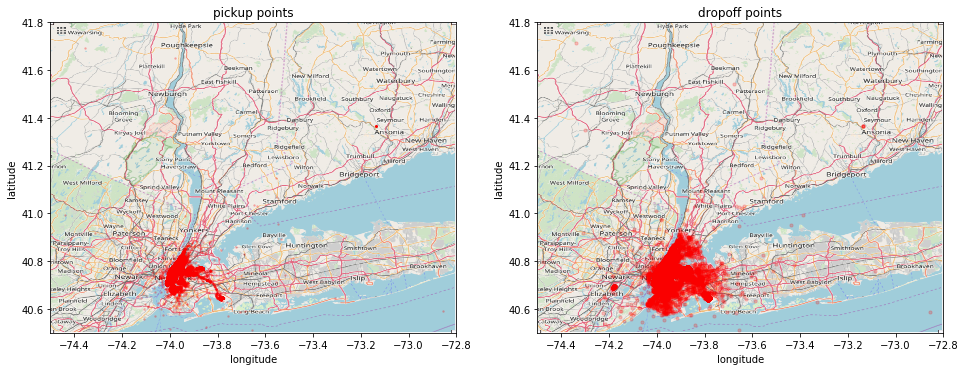

In [23]:
plot_data(train_data,BB)

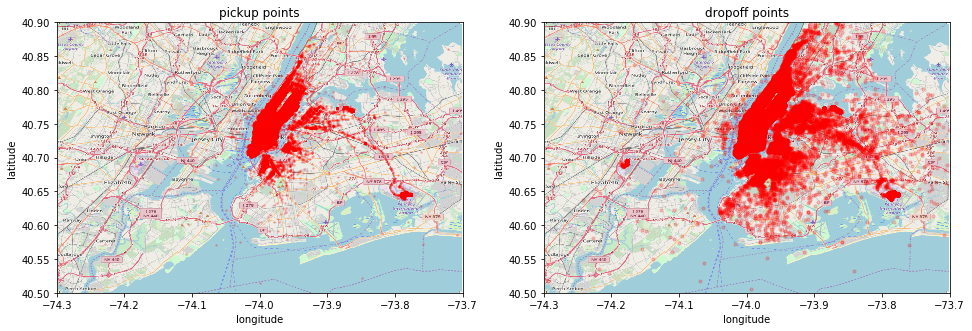

In [24]:
plot_data(train_data,BB_zoom,maps=nyc_map_zoom)

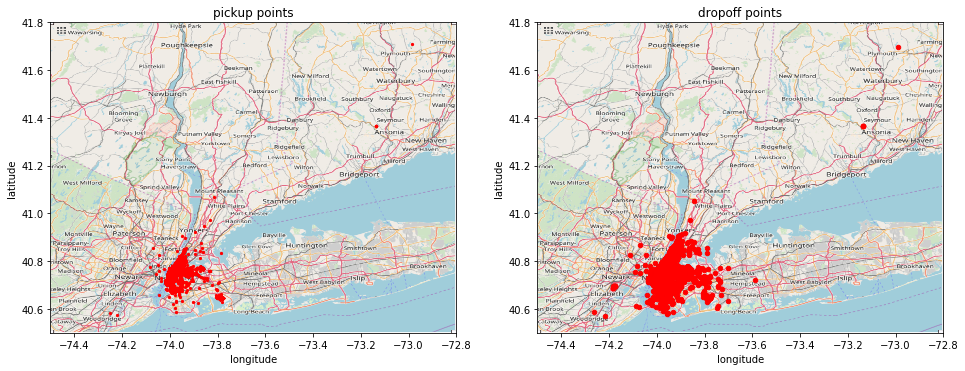

In [25]:
plot_data(test,BB,s=20,alpha=1.0)

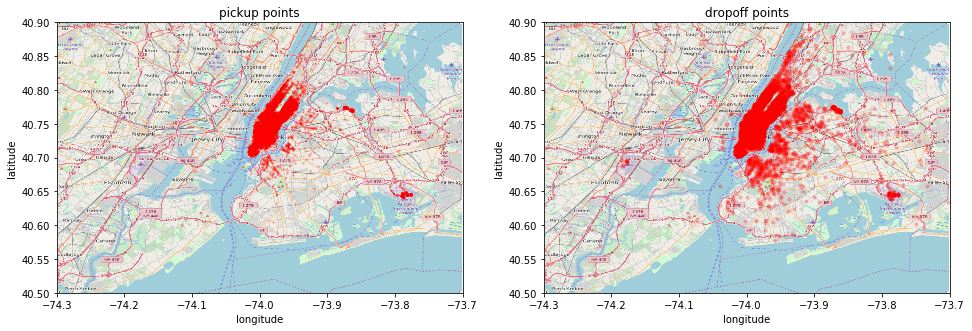

In [26]:
plot_data(test,BB_zoom,maps=nyc_map_zoom)

### remove the points in the water

In [27]:
nyc_mask = plt.imread('nyc_mask.png')

In [28]:
nyc_mask

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0.

In [29]:
nyc_mask = nyc_mask[:,:,0] > 0.9

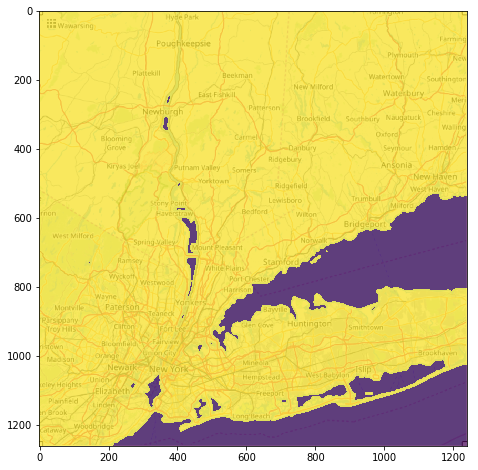

In [33]:
plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7);

(635, 315, 4)


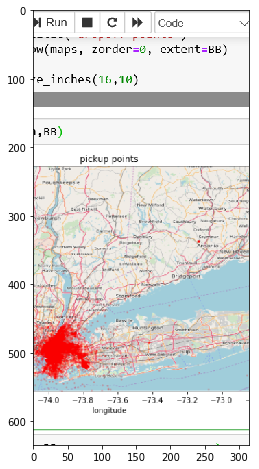

In [34]:
# to test the direction of the axis
# .shape[1] is x-axis; y-axis start from top to bottom

testpic = plt.imread('testpic.png')
plt.figure(figsize=(4,8))
print(testpic.shape)
plt.imshow(testpic)

In [35]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [36]:
pickup_x, pickup_y = lonlat_to_xy(train_data.pickup_longitude, train_data.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(train_data.dropoff_longitude, train_data.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [37]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 20


In [40]:
train_data = train_data[idx]

In [41]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000
mean,11.330338,-73.975403,40.751137,-73.974312,40.751537,1.674839
std,9.520473,0.036199,0.028261,0.035109,0.031479,1.300707
min,0.010000,-74.438232,40.511086,-74.474594,40.517769,0.000000
25%,6.000000,-73.992279,40.736703,-73.991402,40.735818,1.000000
50%,8.500000,-73.982101,40.753557,-73.980461,40.753998,1.000000
75%,12.500000,-73.968460,40.767692,-73.965326,40.768501,2.000000
max,165.000000,-73.085747,41.692429,-73.085762,41.714634,6.000000


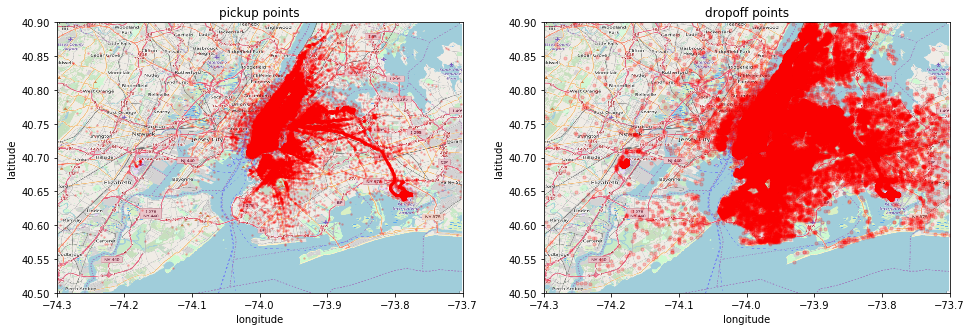

In [35]:
plot_data(train_data,BB_zoom,maps=nyc_map_zoom)


### divide the timestamp

In [43]:
train_data['year'] = train_data['pickup_datetime'].apply(lambda x: x.year)
train_data['month'] = train_data['pickup_datetime'].apply(lambda x: x.month)
train_data['weekday'] = train_data['pickup_datetime'].apply(lambda x: x.weekday()+1)
train_data['hour'] = train_data['pickup_datetime'].apply(lambda x: x.hour)

In [44]:
train_data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,1,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,2,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,4,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,6,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,2,7


In [45]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
count,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000,96666.000000
mean,11.330338,-73.975403,40.751137,-73.974312,40.751537,1.674839,2011.748433,6.263185,4.037769,13.497083
std,9.520473,0.036199,0.028261,0.035109,0.031479,1.300707,1.870007,3.452740,1.949168,6.504403
min,0.010000,-74.438232,40.511086,-74.474594,40.517769,0.000000,2009.000000,1.000000,1.000000,0.000000
25%,6.000000,-73.992279,40.736703,-73.991402,40.735818,1.000000,2010.000000,3.000000,2.000000,9.000000
50%,8.500000,-73.982101,40.753557,-73.980461,40.753998,1.000000,2012.000000,6.000000,4.000000,14.000000
75%,12.500000,-73.968460,40.767692,-73.965326,40.768501,2.000000,2013.000000,9.000000,6.000000,19.000000
max,165.000000,-73.085747,41.692429,-73.085762,41.714634,6.000000,2015.000000,12.000000,7.000000,23.000000


# change axis, based on most of the points

In [46]:
train_data_tr = train_data.copy()

In [47]:
len(train_data_tr),len(train_data)

(96666, 96666)

In [48]:
train_data_tr

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,2009-06-15 17:26:21.0000001,4.500000,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,1,17
1,2010-01-05 16:52:16.0000002,16.900000,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,2,16
2,2011-08-18 00:35:00.00000049,5.700000,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,4,0
3,2012-04-21 04:30:42.0000001,7.700000,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,6,4
4,2010-03-09 07:51:00.000000135,5.300000,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,2,7
5,2011-01-06 09:50:45.0000002,12.100000,2011-01-06 09:50:45,-74.000961,40.731628,-73.972893,40.758232,1,2011,1,4,9
6,2012-11-20 20:35:00.0000001,7.500000,2012-11-20 20:35:00,-73.980003,40.751663,-73.973801,40.764843,1,2012,11,2,20
7,2012-01-04 17:22:00.00000081,16.500000,2012-01-04 17:22:00,-73.951302,40.774139,-73.990097,40.751049,1,2012,1,3,17
8,2012-12-03 13:10:00.000000125,9.000000,2012-12-03 13:10:00,-74.006462,40.726711,-73.993080,40.731628,1,2012,12,1,13
9,2009-09-02 01:11:00.00000083,8.900000,2009-09-02 01:11:00,-73.980659,40.733871,-73.991539,40.758137,2,2009,9,3,1


In [49]:
train_data_tr = train_data_tr.loc[:,('fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','month',
                                     'weekday','hour')].values

In [50]:
train_data_tr.shape

(96666, 8)

In [51]:
train_data_tr[0:5,]

array([[  4.5       , -73.84431458,  40.72131729, -73.84161377,
         40.71227646,   6.        ,   1.        ,  17.        ],
       [ 16.89999962, -74.01604462,  40.71130371, -73.97927094,
         40.78200531,   1.        ,   2.        ,  16.        ],
       [  5.69999981, -73.98273468,  40.76126862, -73.99124146,
         40.75056076,   8.        ,   4.        ,   0.        ],
       [  7.69999981, -73.98712921,  40.73314285, -73.99156952,
         40.75809097,   4.        ,   6.        ,   4.        ],
       [  5.30000019, -73.96809387,  40.76800919, -73.95665741,
         40.78376389,   3.        ,   2.        ,   7.        ]])

In [52]:
# chage pickup
for i in range(train_data_tr.shape[0]):
    train_data_tr[i][1]=np.cos(-1.178)*train_data_tr[i][1] + np.sin(-1.178)*train_data_tr[i][2]  #cos(angle)*(data.pickup_longitude) + sin(angle)*(data.pickup_latitude)
    train_data_tr[i][2]=np.cos(-1.178)*train_data_tr[i][2] - np.sin(-1.178)*train_data_tr[i][1]
train_data_tr[0:10,0:4]

array([[  4.5       , -65.885706  , -45.28097118, -73.84161377],
       [ 16.89999962, -65.9421887 , -45.33698522, -73.97927094],
       [  5.69999981, -65.97559824, -45.34872514, -73.99124146],
       [  7.69999981, -65.95129658, -45.33704003, -73.99156952],
       [  5.30000019, -65.97622136, -45.34672069, -73.95665741],
       [ 12.10000038, -65.95519204, -45.3412185 , -73.97289276],
       [  7.5       , -65.96567888, -45.34323791, -73.97380066],
       [ 16.5       , -65.97545707, -45.34366812, -73.99009705],
       [  9.        , -65.95275493, -45.34084915, -73.99308014],
       [  8.89999962, -65.94949326, -45.33509515, -73.991539  ]])

In [53]:
# dropoff chage
for i in range(train_data_tr.shape[0]):  
    train_data_tr[i][3]=np.cos(-1.178)*train_data_tr[i][3] + np.sin(-1.178)*train_data_tr[i][4]  #cos(angle)*(data.pickup_longitude) + sin(angle)*(data.pickup_latitude)
    train_data_tr[i][4]=np.cos(-1.178)*train_data_tr[i][4] - np.sin(-1.178)*train_data_tr[i][3]
train_data_tr[0:10,0:4]

array([[  4.5       , -65.885706  , -45.28097118, -65.8763199 ],
       [ 16.89999962, -65.9421887 , -45.33698522, -65.99342985],
       [  5.69999981, -65.97559824, -45.34872514, -65.96896204],
       [  7.69999981, -65.95129658, -45.33704003, -65.97604434],
       [  5.30000019, -65.97622136, -45.34672069, -65.98639864],
       [ 12.10000038, -65.95519204, -45.3412185 , -65.96902577],
       [  7.5       , -65.96567888, -45.34323791, -65.97548069],
       [ 16.5       , -65.97545707, -45.34366812, -65.96897509],
       [  9.        , -65.95275493, -45.34084915, -65.95217534],
       [  8.89999962, -65.94949326, -45.33509515, -65.97607495]])

# calculate maha distance using new coordinates

In [54]:
train_data_tr[0:10,0:4]

array([[  4.5       , -65.885706  , -45.28097118, -65.8763199 ],
       [ 16.89999962, -65.9421887 , -45.33698522, -65.99342985],
       [  5.69999981, -65.97559824, -45.34872514, -65.96896204],
       [  7.69999981, -65.95129658, -45.33704003, -65.97604434],
       [  5.30000019, -65.97622136, -45.34672069, -65.98639864],
       [ 12.10000038, -65.95519204, -45.3412185 , -65.96902577],
       [  7.5       , -65.96567888, -45.34323791, -65.97548069],
       [ 16.5       , -65.97545707, -45.34366812, -65.96897509],
       [  9.        , -65.95275493, -45.34084915, -65.95217534],
       [  8.89999962, -65.94949326, -45.33509515, -65.97607495]])

In [55]:
def maha(df):
    maha = np.abs(df[:,4] - df[:,2]) + np.abs(df[:,3] - df[:,1])
    return maha

In [56]:
m_distance = maha(train_data_tr)
m_distance.shape

(96666,)

In [57]:
train_data_tr = np.column_stack((train_data_tr,m_distance))

In [58]:
train_data_tr.shape,len(train_data_tr)

((96666, 9), 96666)

In [59]:
m_distance

array([0.01459679, 0.0715172 , 0.00866833, ..., 0.00189538, 0.01381073,
       0.0184034 ])

In [60]:
train_data_tr[0:5,]

array([[ 4.50000000e+00, -6.58857060e+01, -4.52809712e+01,
        -6.58763199e+01, -4.52757605e+01,  6.00000000e+00,
         1.00000000e+00,  1.70000000e+01,  1.45967870e-02],
       [ 1.68999996e+01, -6.59421887e+01, -4.53369852e+01,
        -6.59934299e+01, -4.53572613e+01,  1.00000000e+00,
         2.00000000e+00,  1.60000000e+01,  7.15172032e-02],
       [ 5.69999981e+00, -6.59755982e+01, -4.53487251e+01,
        -6.59689620e+01, -4.53466930e+01,  8.00000000e+00,
         4.00000000e+00,  0.00000000e+00,  8.66832864e-03],
       [ 7.69999981e+00, -6.59512966e+01, -4.53370400e+01,
        -6.59760443e+01, -4.53503536e+01,  4.00000000e+00,
         6.00000000e+00,  4.00000000e+00,  3.80613145e-02],
       [ 5.30000019e+00, -6.59762214e+01, -4.53467207e+01,
        -6.59863986e+01, -4.53500924e+01,  3.00000000e+00,
         2.00000000e+00,  7.00000000e+00,  1.35490156e-02]])

# decomposition 


In [72]:
train_df = pd.DataFrame(train_data_tr, columns=['fare_amount','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','month',
                                     'weekday','hour','man_dis'])

In [73]:
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,man_dis
0,4.5,-65.885706,-45.280971,-65.876320,-45.275760,6.0,1.0,17.0,0.014597
1,16.9,-65.942189,-45.336985,-65.993430,-45.357261,1.0,2.0,16.0,0.071517
2,5.7,-65.975598,-45.348725,-65.968962,-45.346693,8.0,4.0,0.0,0.008668
3,7.7,-65.951297,-45.337040,-65.976044,-45.350354,4.0,6.0,4.0,0.038061
4,5.3,-65.976221,-45.346721,-65.986399,-45.350092,3.0,2.0,7.0,0.013549


In [74]:
train_sorted = train_df.sort_values(by='man_dis')

In [75]:
train_sorted.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,man_dis
594,16.0,-65.807125,-45.232972,-65.807114,-45.232968,10.0,6.0,20.0,0.000015
179,4.5,-65.966363,-45.342328,-65.966401,-45.342350,2.0,3.0,14.0,0.000059
890,2.5,-65.921477,-45.317387,-65.921217,-45.317274,8.0,2.0,23.0,0.000373
215,3.3,-65.970102,-45.347998,-65.970547,-45.348025,2.0,2.0,9.0,0.000472
219,2.5,-65.940022,-45.331615,-65.940396,-45.331748,3.0,4.0,3.0,0.000507


Text(0,0.5,'fare amount')

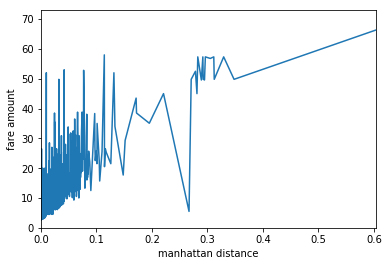

In [76]:
fig,axs = plt.subplots()
axs.plot(train_sorted['man_dis'],train_sorted['fare_amount'])
axs.set_xlim(0,train_df.man_dis.max())
axs.set_ylim(0,train_df.fare_amount.max()*1.1)
axs.xaxis.set_label_text('manhattan distance')
axs.yaxis.set_label_text('fare amount')


(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0.10325355, 0.20325355, 0.30325355, 0.40325355, 0.50325355,
        0.60325355, 0.70325355, 0.80325355, 0.90325355, 1.00325355,
        1.10325355]),
 <a list of 10 Patch objects>)

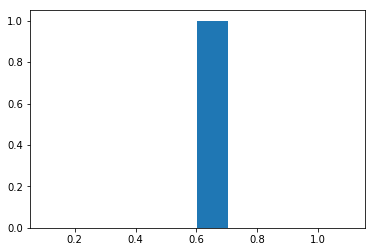

In [77]:
plt.hist(train_sorted[train_sorted['man_dis']>0.4]['man_dis'])

In [78]:
len(train_sorted[train_sorted['man_dis']>0.25])

17

In [79]:
train_left = train_sorted[train_sorted['man_dis']<0.4]

Text(0,0.5,'fare amount')

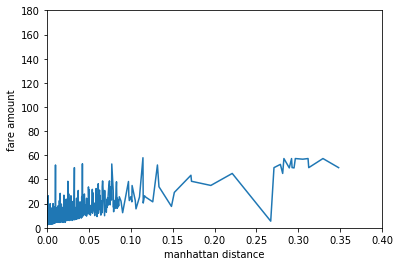

In [80]:
fig,axs = plt.subplots()
axs.plot(train_left['man_dis'],train_left['fare_amount'])
axs.set_xlim(0,0.4)
axs.set_ylim(0,180)
axs.xaxis.set_label_text('manhattan distance')
axs.yaxis.set_label_text('fare amount')


In [81]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(train_left['man_dis'],train_left['fare_amount'])
print('intercept =', intercept, '    slope =', slope, '     p_value = ',p_value)

intercept = 6.622499155717794     slope = 164.92626560784996      p_value =  2.3532522563752763e-192


In [82]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row[8]) * slope
    
train_left['regress'] = train_left.apply(create_regress_col,args = (intercept,slope),axis = "columns")
'''
train_sorted.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format
})
'''

D:\Anaconda_app\envs\cs231n\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


"\ntrain_sorted.style.format({\n    'Product1Demand': '{:,.0f}'.format,\n    'regress': '{:,.0f}'.format\n})\n"

In [83]:
train_left.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,man_dis,regress
594,16.0,-65.807125,-45.232972,-65.807114,-45.232968,10.0,6.0,20.0,0.000015,6.625033
179,4.5,-65.966363,-45.342328,-65.966401,-45.342350,2.0,3.0,14.0,0.000059,6.632249
890,2.5,-65.921477,-45.317387,-65.921217,-45.317274,8.0,2.0,23.0,0.000373,6.684005
215,3.3,-65.970102,-45.347998,-65.970547,-45.348025,2.0,2.0,9.0,0.000472,6.700360
219,2.5,-65.940022,-45.331615,-65.940396,-45.331748,3.0,4.0,3.0,0.000507,6.706119


In [84]:
train_left['R1'] = train_left['fare_amount'] - train_left['regress']

D:\Anaconda_app\envs\cs231n\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


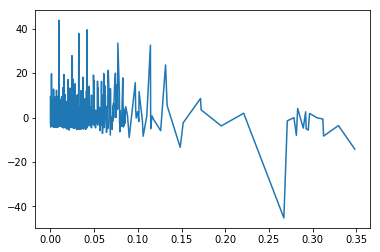

In [85]:
plt.plot(train_left['man_dis'],train_left['R1'])


In [86]:
train_left = train_left[train_left['fare_amount']<100]

In [87]:
train_left.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,man_dis,regress,R1
594,16.0,-65.807125,-45.232972,-65.807114,-45.232968,10.0,6.0,20.0,0.000015,6.625033,9.374967
179,4.5,-65.966363,-45.342328,-65.966401,-45.342350,2.0,3.0,14.0,0.000059,6.632249,-2.132249
890,2.5,-65.921477,-45.317387,-65.921217,-45.317274,8.0,2.0,23.0,0.000373,6.684005,-4.184005
215,3.3,-65.970102,-45.347998,-65.970547,-45.348025,2.0,2.0,9.0,0.000472,6.700360,-3.400360
219,2.5,-65.940022,-45.331615,-65.940396,-45.331748,3.0,4.0,3.0,0.000507,6.706119,-4.206119


In [88]:
train_left.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,month,weekday,hour,man_dis,regress,R1
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,9.630000e+02
mean,11.386646,-65.964066,-45.341826,-65.963545,-45.341229,6.057113,3.994808,13.554517,0.028887,11.386646,7.525998e-16
std,9.159724,0.026920,0.016912,0.029841,0.017825,3.438781,1.960889,6.321258,0.042947,7.083037,5.807850e+00
min,2.500000,-66.030774,-45.370438,-66.058625,-45.379263,1.000000,1.000000,0.000000,0.000015,6.625033,-4.516531e+01
25%,6.000000,-65.976618,-45.348669,-65.977373,-45.348657,3.000000,2.000000,9.000000,0.008441,8.014591,-3.230014e+00
50%,8.500000,-65.967760,-45.344175,-65.968312,-45.344076,6.000000,4.000000,14.000000,0.016705,9.377640,-1.716754e+00
75%,13.000000,-65.955911,-45.339646,-65.952240,-45.338278,9.000000,6.000000,19.000000,0.033023,12.068794,1.286023e+00
max,58.000000,-65.789582,-45.221279,-65.790656,-45.220537,12.000000,7.000000,23.000000,0.348159,64.043064,4.374443e+01


# check point

## got y and divide in val and train

In [89]:
data_train = train_df.iloc[:,5:].values

In [90]:
fare_train = train_df['fare_amount'].values

In [91]:
fare_train.shape, data_train.shape

((964,), (964, 4))

In [93]:
line = int(0.9*len(train_data))
train_x = data_train[0:line,:]
val_x = data_train[line:,:]
train_y = fare_train[0:line]
val_y = fare_train[line:]

In [94]:
len(train_x),len(val_x),len(val_y),len(train_y)

(867, 97, 97, 867)

In [95]:
train_x.shape, val_x.shape, val_y.shape,train_y.shape

((867, 4), (97, 4), (97,), (867,))

## normalize the data

In [61]:
train_x

array([[6.00000000e+00, 1.00000000e+00, 1.70000000e+01, 1.45967870e-02],
       [1.00000000e+00, 2.00000000e+00, 1.60000000e+01, 7.15172032e-02],
       [8.00000000e+00, 4.00000000e+00, 0.00000000e+00, 8.66832864e-03],
       ...,
       [9.00000000e+00, 3.00000000e+00, 1.60000000e+01, 2.74649727e-03],
       [1.00000000e+00, 2.00000000e+00, 1.40000000e+01, 3.56598129e-02],
       [1.00000000e+00, 3.00000000e+00, 1.80000000e+01, 2.37793199e-02]])

In [96]:
mean = np.mean(train_x,axis=0)
std = np.std(train_x,axis=0)
train_X_n = (train_x -mean)/std
val_X_n = (val_x-mean)/std

In [97]:
trainX = train_X_n.T
valX = val_X_n.T
trainY = train_y.reshape(1,-1)
valY = val_y.reshape(1,-1)

In [98]:
trainX.shape, valX.shape,trainY.shape, valY.shape

((4, 867), (4, 97), (1, 867), (1, 97))

In [99]:
trainX[:,0:20],trainY[:,0:20], valX[:,0:20], valY[:,0:20]

(array([[-0.01282852, -1.47629278,  0.57255718, -0.59821422, -0.89090708,
         -1.47629278,  1.45063573, -1.47629278,  1.74332859,  0.86525003,
         -0.59821422,  1.45063573,  0.27986433, -0.59821422, -1.18359993,
          0.27986433,  0.27986433,  1.74332859,  0.86525003, -1.18359993],
        [-1.53905723, -1.02878472, -0.00823969,  1.01230533, -1.02878472,
         -0.00823969, -1.02878472, -0.51851221, -1.53905723, -0.51851221,
          1.52257784,  0.50203282, -1.02878472, -1.02878472, -0.51851221,
         -0.51851221, -0.51851221,  1.01230533, -1.02878472, -1.02878472],
        [ 0.55270098,  0.39533095, -2.12258958, -1.49310945, -1.02099935,
         -0.70625928,  1.02481108,  0.55270098, -0.07677915, -1.96521954,
         -1.02099935, -1.96521954,  0.86744105,  0.55270098, -1.02099935,
          0.39533095,  0.08059088,  1.02481108, -0.07677915, -0.23414918],
        [-0.32092187,  0.89340486, -0.4473982 ,  0.17966483, -0.34327477,
         -0.28179676, -0.33765855, 

## build Neural Network from scratch: forward pass, back propagation, loss function, adam...

In [77]:
# define functions

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    n_x: dimention of X
    n_y: dimention of Y
    """
    X = tf.placeholder(tf.float32,(n_x,None),name='X')
    Y = tf.placeholder(tf.float32,(n_y,None),name='Y')
    
    return X, Y

def he_init(layers_dims):
   # tf.reset_default_graph()
    parameters = {}
    L = len(layers_dims) -1
    for l in range(1, L+1):
        parameters['W'+str(l)] = tf.get_variable('W'+str(l),[layers_dims[l],layers_dims[l-1]],
                                                 initializer=tf.contrib.layers.variance_scaling_initializer())
        parameters['b'+str(l)] = tf.get_variable('b'+str(l),[layers_dims[l],1],initializer=tf.zeros_initializer())
        
        assert(parameters['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layers_dims[l], 1))   
    return parameters

        

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = tf.add(tf.matmul(W,A),b)  
    
   # assert(Z.shape == (W.shape[0], A.shape[1]))
    
    return Z


def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z = linear_forward(A_prev, W, b)
        A = tf.nn.sigmoid(Z)
    if activation == "tanh":
        Z = linear_forward(A_prev,W,b)
        A = tf.tanh(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z = linear_forward(A_prev, W, b)
        A = tf.nn.relu(Z)
    
  #  assert (A.shape == (W.shape[0], A_prev.shape[1]))
  
    return A 

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL = linear_forward(A, parameters['W' + str(L)], parameters['b' + str(L)])
    #AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    
  #  assert(AL.shape == (1,X.shape[1]))
            
    return AL

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = tf.reduce_mean(tf.square(Y-AL))

    #cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    return cost


def predict(X,y,parameters):
    m = X.shape[1]
    
    A4,cache = forward_prop(X,parameters)
    
    p = np.zeros((1,m))
    for i in range(0,A4.shape[1]):
        if A4[0,i] > 0.5:
            p[0,i] =1
        else:
            p[0,i] =0
    print('accuracy rate is: ',np.mean((p[0,:]==y[0,:])))
    
    return p



def get_batch(X,y,batch_size):
    m = X.shape[1]
    perm = np.random.permutation(m)
    X_perm = X[:,perm]
    y_perm = y[:,perm]
    
    n = np.int(m/batch_size)
    batches = []
    for i in range(n):
        X_batch = X_perm[:,i*batch_size:(i+1)*batch_size]
        y_batch = y_perm[:,i*batch_size:(i+1)*batch_size]
        batches.append((X_batch,y_batch))
    if m%batch_size != 0:
        X_batch = X_perm[:,n*batch_size:]
        y_batch = y_perm[:,n*batch_size:]       
        batches.append((X_batch,y_batch))
    return batches
    
def predict_dec(X_test,y_test,parameters):
    (n_x, m) = X_test.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = y_test.shape[0] 
    X, Y = create_placeholders(n_x,n_y)
    AL= L_model_forward(X, parameters)
    RMSE = tf.sqrt(tf.reduce_mean(tf.square(AL - Y)))
    with tf.Session() as sess:
        val=sess.run(RMSE,feed_dict={X:X_test,Y:y_test})

    return val

'''
L = len(layers_dims) -1
for l in range(1, L+1):
    tf.summary.histogram("weight_"+str(l),parameters['W'+str(l)] )



tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()
filename="./summary_log_cifar/run"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
writer = tf.summary.FileWriter(filename, tf.get_default_graph())
'''

'\nL = len(layers_dims) -1\nfor l in range(1, L+1):\n    tf.summary.histogram("weight_"+str(l),parameters[\'W\'+str(l)] )\n\n\n\ntf.summary.scalar("loss", loss)\nmerged_summary_op = tf.summary.merge_all()\nfilename="./summary_log_cifar/run"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")\nwriter = tf.summary.FileWriter(filename, tf.get_default_graph())\n'

In [78]:

layers_dims = [4, 256,256, 128, 64,64, 32, 32,16,4, 1] #  11-layer model

In [86]:
def model_tf(X_train, Y_train, X_test, Y_test, layers_dims, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 16, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables                       # to keep consistent results                                        # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    parameters={}
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x,n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = he_init(layers_dims)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    AL = L_model_forward(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(AL, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            #minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            minibatches = get_batch(X_train,Y_train,minibatch_size)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
       
                _ , minibatch_cost= sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                
                epoch_cost += minibatch_cost / num_minibatches
            #writer.add_summary(merged_summary, epoch)
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        '''
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(AL), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        '''
        return parameters

In [87]:
trainX[:,0:10],trainY[:,0:10]

(array([[-0.07819367, -1.53222344,  0.50341823, -0.65980558, -0.95061154,
         -1.53222344,  1.37583609, -1.53222344,  1.66664205,  0.79422419],
        [-1.55839925, -1.04552946, -0.01978988,  1.0059497 , -1.04552946,
         -0.01978988, -1.04552946, -0.53265967, -1.55839925, -0.53265967],
        [ 0.5354345 ,  0.38185979, -2.0753355 , -1.46103668, -1.00031256,
         -0.69316315,  0.99615861,  0.5354345 , -0.07886433, -1.9217608 ],
        [-0.34997913,  0.94779298, -0.48514659,  0.18500658, -0.37386807,
         -0.30816545, -0.36786591, -0.47001443, -0.61444721,  0.27140766]]),
 array([[ 4.5       , 16.89999962,  5.69999981,  7.69999981,  5.30000019,
         12.10000038,  7.5       , 16.5       ,  9.        ,  8.89999962]]))

In [88]:
para = model_tf(trainX, trainY, valX,valY,layers_dims,print_cost = True)

Cost after epoch 0: 169.945811


KeyboardInterrupt: 

In [83]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def tanh(Z):
    A = (np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache
def linear_forward1(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache


def linear_activation_forward1(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward1(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    if activation == "tanh":
        Z, linear_cache = linear_forward1(A_prev,W,b)
        A, activation_cache = tanh(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward1(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward1(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward1(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_forward1(A, parameters['W' + str(L)], parameters['b' + str(L)])
    #AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches
def predict_dec1(X_test,y_test,parameters):
    AL, cache = L_model_forward1(X_test, parameters)
    n = X_test.shape[1]
    RMSE = np.sqrt(np.sum((AL - y_test)**2) / n)
    
    return RMSE

In [84]:
RMSE = predict_dec1(valX,valY,para)

In [85]:
RMSE

5.94906259811309